In [129]:
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# models
from sklearn.linear_model import LogisticRegression
from sklearn import svm

In [130]:
### LOAD DATA FROM CSV INTO SQL DATABASE
DB_FILE = 'netflix.db'
# if DB file does not exist use the csv data to populate it
if not os.path.exists(DB_FILE):    
    titles = pd.read_csv('titles.csv')
    # make the database connection
    dbcon = sqlite3.connect(DB_FILE)
    # create empty tables with the correct relationships for population with the csv data
    create_titles = '''CREATE TABLE IF NOT EXISTS Titles (
                                            id TEXT PRIMARY KEY,
                                            title TEXT,
                                            type TEXT,
                                            description TEXT,
                                            release_year INTEGER,
                                            age_certification TEXT,
                                            runtime INTEGER,
                                            genres TEXT,
                                            production_countries TEXT,
                                            seasons INTEGER,
                                            imdb_id TEXT,
                                            imdb_score INTEGER,
                                            imdb_votes INTEGER,
                                            tmdb_popularity INTEGER,
                                            tmdb_score INTEGER
                                        );'''
    create_credits = '''CREATE TABLE IF NOT EXISTS Credits (
                                            person_id INTEGER NOT NULL,
                                            id TEXT NOT NULL,
                                            name TEXT NOT NULL,
                                            character TEXT,
                                            role TEXT,
                                            in_2021 INTEGER DEFAULT 0,
                                            FOREIGN KEY (id) REFERENCES title(id)
                                        );'''
    
    cur = dbcon.cursor() # create the above empty tables
    cur.execute(create_titles)
    cur.execute(create_credits)
    
    # use pandas to read the data for easy storage into the SQLite db
    titles = pd.read_csv('titles.csv')
    titles.to_sql('Titles', con=dbcon, if_exists='append', index=False)
    
    credits = pd.read_csv('credits.csv')
    credits.to_sql('Credits', con=dbcon, if_exists='append', index=False)
    dbcon.commit()
    # Create a column for wether or not this person is in 2021, used for logistic regression
    cur.execute('''
    UPDATE Credits
    SET in_2021 = 1
    WHERE Credits.person_id IN
    (
        SELECT Credits.person_id
        FROM Credits
        INNER JOIN Titles ON Titles.id = Credits.id
        WHERE Titles.release_year >= 2021
        GROUP BY Credits.person_id
    )
    ''')
    dbcon.commit()
    dbcon.close()


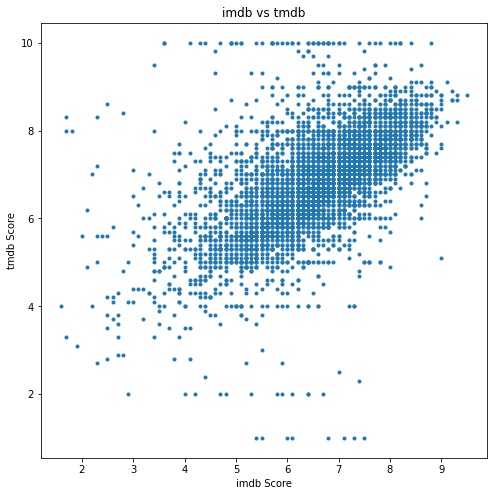

In [131]:
# EDA
dbcon = sqlite3.connect(DB_FILE)
cur = dbcon.cursor()

cur.execute('''
SELECT imdb_score, tmdb_score FROM Titles WHERE imdb_score NOT NULL AND tmdb_score NOT NULL
''')
cur.row_factory = lambda cursor, row: list(row)
scores = np.array(cur.fetchall()).T

#print(scores[0])
plt.rcParams["figure.figsize"] = (8,8)

plt.scatter(scores[0], scores[1], marker='.')

plt.title('imdb vs tmdb')
plt.xlabel('imdb Score')
plt.ylabel('tmdb Score')
plt.show()

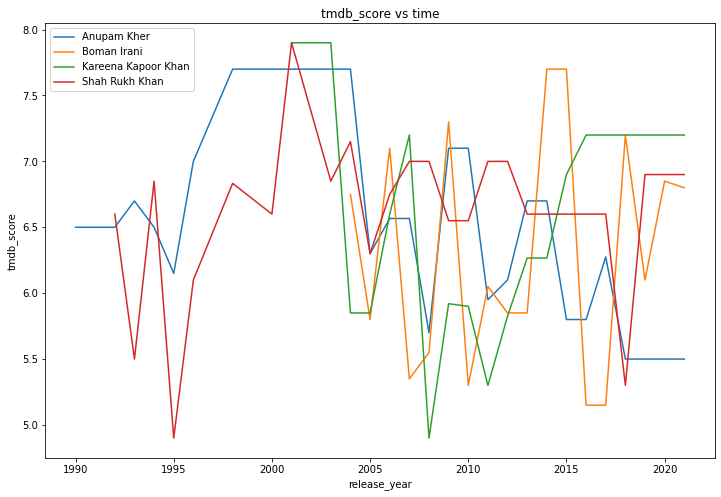

In [132]:
## MORE EDA
cur.row_factory = lambda cursor, row: list(row)

score_metric = 'tmdb_score'
star_query = '''
SELECT name, release_year, '''+score_metric+''' FROM
(
    SELECT  Credits.name, Titles.release_year, Titles.'''+score_metric+''', 
        COUNT(Credits.person_id) OVER (PARTITION BY Credits.person_id) AS freq
    FROM Credits
    INNER JOIN Titles ON Titles.id = Credits.id
    ORDER BY Titles.release_year
)
WHERE freq > 24
'''
star_scores = pd.read_sql_query(star_query, dbcon)
star_scores = star_scores.pivot_table(index='release_year', columns='name')
star_scores.columns = [col[1] for col in star_scores.columns]
star_scores.fillna(method='ffill', inplace=True)

plt.rcParams["figure.figsize"] = (12,8)
star_scores.plot(kind='line')
plt.ylabel(score_metric)
plt.title(score_metric + ' vs time')
plt.show()

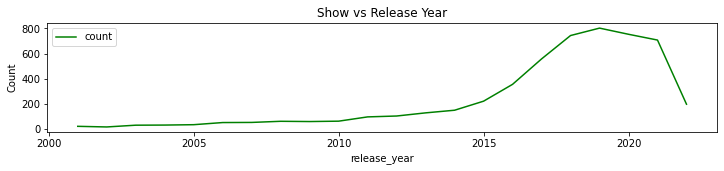

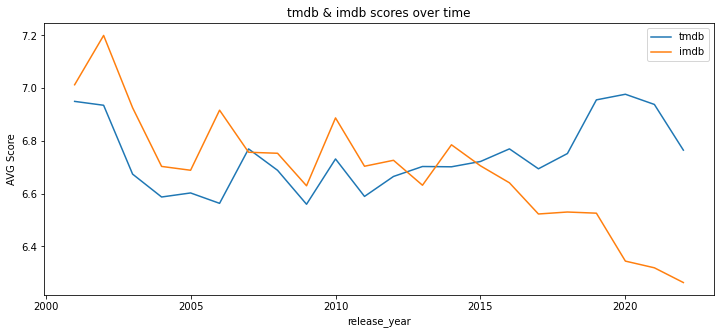

In [133]:
score_timeline = '''
SELECT release_year, count, imdb, tmdb FROM
(
    SELECT  Titles.release_year, 
        COUNT(Titles.tmdb_score) as count,
        AVG(Titles.imdb_score) as imdb,
        AVG(Titles.tmdb_score) as tmdb
    FROM Titles
    WHERE Titles.release_year > 2000
    GROUP BY Titles.release_year
    ORDER BY Titles.release_year DESC
)
'''
scores = pd.read_sql_query(score_timeline, dbcon).dropna()

plt.rcParams["figure.figsize"] = (12,2)
scores.plot(x='release_year', y=['count'], subplots=True, kind='line', ylabel='Count', color='green')
plt.title('Show vs Release Year')
plt.show()

plt.rcParams["figure.figsize"] = (12,5)
scores.plot(x='release_year', y=['tmdb', 'imdb'], kind='line', ylabel='AVG Score')
plt.title('tmdb & imdb scores over time')
plt.show()

In [134]:
## only include people who appear more than thrice and after 2010
## since otherwise they are not really 'up and coming'. 
## Also cannot appear in the same movie in the same year (which seems like an error)
## the WHERE clause can be changed for different sets, right now it only selects productions in the US
popular_query = '''
SELECT  name, release_year, imdb_score, tmdb_score, in_2021, freq FROM
(
    SELECT  name, release_year, imdb_score, tmdb_score, in_2021, COUNT(person_id) OVER(PARTITION BY person_id) AS freq FROM
    (
        SELECT  Credits.name, Titles.release_year, Titles.imdb_score, 
            Titles.tmdb_score, Credits.in_2021, Credits.person_id
        FROM Credits
        INNER JOIN Titles ON Titles.id = Credits.id
        WHERE Titles.release_year > 2010 AND Titles.release_year < 2021 AND
            (Titles.imdb_score NOT NULL OR Titles.tmdb_score NOT NULL) AND
            Titles.production_countries LIKE '%US%'
        GROUP BY Credits.person_id, Titles.release_year, Titles.id
        ORDER BY Credits.name, Titles.release_year
    )
)
WHERE freq >= 3
'''
pop_ppl = pd.read_sql_query(popular_query, dbcon)

# make a metric which is the change on a persons in the last 10 years
# if the earliest or latest score cannot be found the average is used instead
def score_delta(scores):
    first = scores.iloc[0]
    last = scores.iloc[-1]
    
    if pd.isna(first):
        return last - scores.mean()
    if pd.isna(last):
        return scores.mean() - first
    return last - first

# Organize data for prediction purposes
# this will make a table with each person as an index and their metrics as columns
pop_ppl = pop_ppl.pivot_table(index='name',  aggfunc=
                    {'release_year': 'last',
                     'in_2021': 'first',
                     'imdb_score': [np.mean, score_delta],
                     'tmdb_score': [np.mean, score_delta],
                     'freq': 'first'}).fillna(0)

pop_ppl.columns = ['freq', 'avg_imdb', 'delta_imdb', 'in_2021', 'last_year', 'avg_tmdb', 'delta_tmdb']

pop_ppl

,freq,avg_imdb,delta_imdb,in_2021,last_year,avg_tmdb,delta_tmdb
name,,,,,,,
50 Cent,3,6.866667,0.800000,0,2020,6.700000,0.8
A.D. Miles,4,6.800000,-0.600000,0,2020,6.550000,0.9
Aaron Eckhart,4,5.675000,-1.300000,0,2016,5.800000,-1.0
Aaron Paul,4,7.733333,-0.633333,0,2019,7.400000,-0.1
Aaron Taylor-Johnson,3,6.933333,0.500000,0,2018,6.900000,0.4
...,...,...,...,...,...,...,...
Zoe Kazan,3,6.600000,0.300000,1,2019,6.466667,0.7
Zoe Saldana,3,6.966667,-1.900000,1,2020,6.566667,-1.6
Zoey Deutch,5,6.675000,1.275000,0,2020,7.200000,1.8


#### A description of these metrics:
- `freq` counts how many productions the person was in since 2010.
- `avg_imdb` and `avg_tmbd` are the average scores for the productions the person was in.
- `delta_imdb` and `delta_tmbd` are the changes to a persons score over the years, negative indicates it went down.
- `in_2021` is a binary indicating wether they were in 2021, this is the value being predicted.
- `last_year` is the most recent year that the person appeared in a production before 2021.

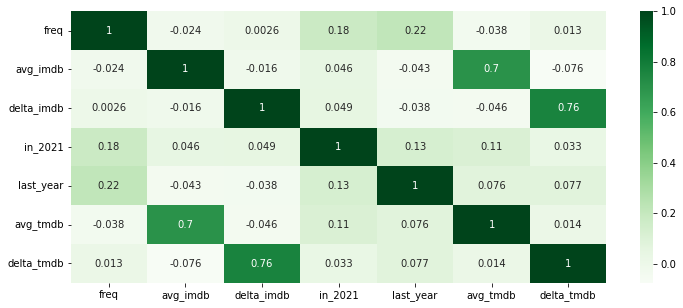

In [135]:
# normalize the input columns for logitsic regression
in_cols = ['freq', 'avg_imdb', 'delta_imdb', 'last_year', 'avg_tmdb', 'delta_tmdb']

normalized = pop_ppl.copy()
# minus mean over std
#normalized[in_cols] = (pop_ppl[in_cols]-pop_ppl[in_cols].mean())/pop_ppl[in_cols].std()
# norm between 0 and 1
normalized[in_cols] = (pop_ppl[in_cols] - pop_ppl[in_cols].min()) / (pop_ppl[in_cols].max()-pop_ppl[in_cols].min())

corrMatrix = normalized.corr()
sns.heatmap(corrMatrix, annot=True, cmap='Greens')
plt.show()

This correlation matrix is not super promising. The `in_2022` column is not very well correlated with anything else. Although it seems the freq has a high correlation which makes sense.

In [136]:
X = pop_ppl[['freq', 'avg_tmdb', 'last_year']]
y = pop_ppl['in_2021']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)


print('--RESULTS--')

predictor = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
print('Logistic Regression score:', predictor.score(X_test, y_test), '\n')

pop_ppl['proba_logit'] = predictor.predict_proba(X).T[1]
print('Top 15 stars:')
print(pop_ppl.sort_values('proba_logit', ascending=False)['proba_logit'][:15])

--RESULTS--
Logistic Regression score: 0.7424892703862661 

Top 15 stars:
name
Jay Karas             0.895562
Marcus Raboy          0.885466
Fred Tatasciore       0.760599
Fred Armisen          0.758050
Tiffany Haddish       0.746667
Kari Wahlgren         0.724601
Natasha Lyonne        0.721464
Keegan-Michael Key    0.717455
Ron Funches           0.682996
Adam Sandler          0.679155
Jay Chapman           0.677272
Andrew Bachelor       0.669385
Grey DeLisle          0.666686
Donald Trump          0.661619
Ryan Polito           0.652983
Name: proba_logit, dtype: float64


Considering the very low correlations between variables and how sparse the data is for a single actor, and averge score of .7 is surprising. However the model can achieve high accuracy by simply marking all persons as not in 2021, since those not in 2021 far outnumber the ones in it.

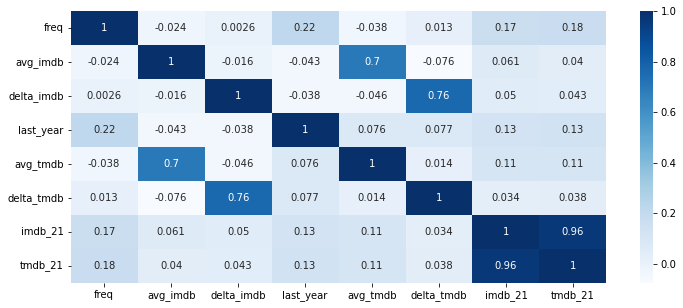

In [144]:
# How about predicting the degree of sucess by predicting the imdb/tmdb score in 2021 instead of just a binary
# Get a list of all people in credits, but with averages for those with imdb scores in 2021
avg_2021 = '''
SELECT  Credits.name,
    AVG(Titles.imdb_score) AS imdb_21, AVG(Titles.tmdb_score) AS tmdb_21
FROM Credits
INNER JOIN Titles ON Titles.id = Credits.id
WHERE Titles.release_year >= 2021
GROUP BY Credits.person_id
'''
scores_2021 = pd.read_sql_query(avg_2021, dbcon, index_col='name')
#scores_2021
pop_ppl_scores = pop_ppl.join(scores_2021, how='left').fillna(0)

corr_cols = ['freq', 'avg_imdb', 'delta_imdb', 'last_year', 'avg_tmdb', 'delta_tmdb', 'imdb_21', 'tmdb_21']

corrMatrix = pop_ppl_scores[corr_cols].corr()
sns.heatmap(corrMatrix, annot=True, cmap='Blues')
plt.show()

This correlation plot shows very much the same thing as the previous one. There are only small correlations in the `imdb_21` and `tmdb_21` rows, thererore I don't have much confidence in a model.